# Crime Prediction using Tweets and KDE

In [1]:
%matplotlib inline

import os
import glob
import itertools
import functools
import collections

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook, tqdm

from utils.consts import START_DATE, END_DATE, \
                         RAW_CRIMES_DATA_PATH, PROCESSED_CRIMES_DATA_PATH, \
                         RAW_TWEETS_DATA_WILDCARD_PATH, PROCESSED_TWEETS_DATA_PATH, \
                         CSV_DATE_FORMART

from utils.lda import print_top_words_LDA, print_top_words_LDA, get_topic_top_words_LDA

from utils.surveillance import generate_all_data_surveillance_data, \
                               generate_one_step_datasets, generate_surveillance_data, calc_AUCs
    
from utils.visualization import plot_contour, plot_scatter, plot_imshow, plot_log_reg_coef, plot_surveillance_data


In [2]:
import warnings
warnings.simplefilter('ignore')

![title](./ANLP-Project-Pipeline.png)

## Research Time Frame

In [3]:
print(START_DATE, '--->', END_DATE)

2017-12-08 ---> 2018-02-19


## Data Sources & Preprocessing

### Chicago Crimes Incidents

In [4]:
if not os.path.exists(PROCESSED_CRIMES_DATA_PATH):
    !python3 ./preprocess_crimes_data.py {RAW_CRIMES_DATA_PATH}  {PROCESSED_CRIMES_DATA_PATH}

In [5]:
crimes_data = pd.read_csv(PROCESSED_CRIMES_DATA_PATH)
crimes_data['timestamp'] = pd.to_datetime(crimes_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()

In [6]:
len(crimes_data)

10902

In [7]:
crimes_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

### Tweets

In [8]:
if not os.path.exists(PROCESSED_TWEETS_DATA_PATH):
    !python3 -W ignore ./preprocess_tweets_data.py {RAW_TWEETS_DATA_WILDCARD_PATH} {PROCESSED_TWEETS_DATA_PATH}

In [9]:
tweets_data = pd.read_csv(PROCESSED_TWEETS_DATA_PATH)
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()
tweets_data['tokens'] = tweets_data['tokens'].apply(lambda x: eval(x))

In [10]:
len(tweets_data)

79634

In [11]:
tweets_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

### Enreaching Tweets with Sentiment Analysis 

In [12]:
from utils.sentiment.sentiment import calculate_sentiment_tweet

Length of the testing Corpus : 10662
Adding unigrams and bigrams sentiment scores 

average fit_time : 0.4645617246627808
average score_time : 0.007820725440979004
average test_f1_micro : 0.7554900886087512
average test_f1_macro : 0.7554053496579932
average test_precision_micro : 0.7554900886087512
average test_precision_macro : 0.7558688268181593
average test_recall_micro : 0.7554900886087512
average test_recall_macro : 0.7554900886087512


In [13]:
tweets_data['sentiment'] = tweets_data['tokens'].apply(lambda x: calculate_sentiment_tweet(' '.join(x)))

### one month

In [15]:
train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                               tweets_data,
                                                               START_DATE,
                                                               31)

## KDE

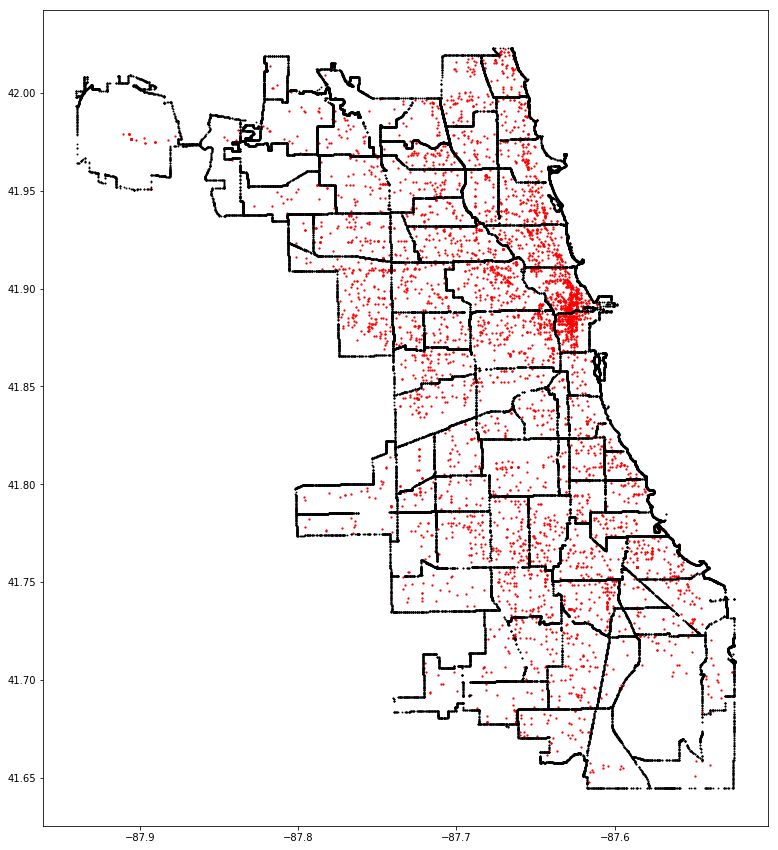

In [16]:
plot_scatter(train_dataset['X'][train_dataset['Y']][['latitude', 'longitude']])

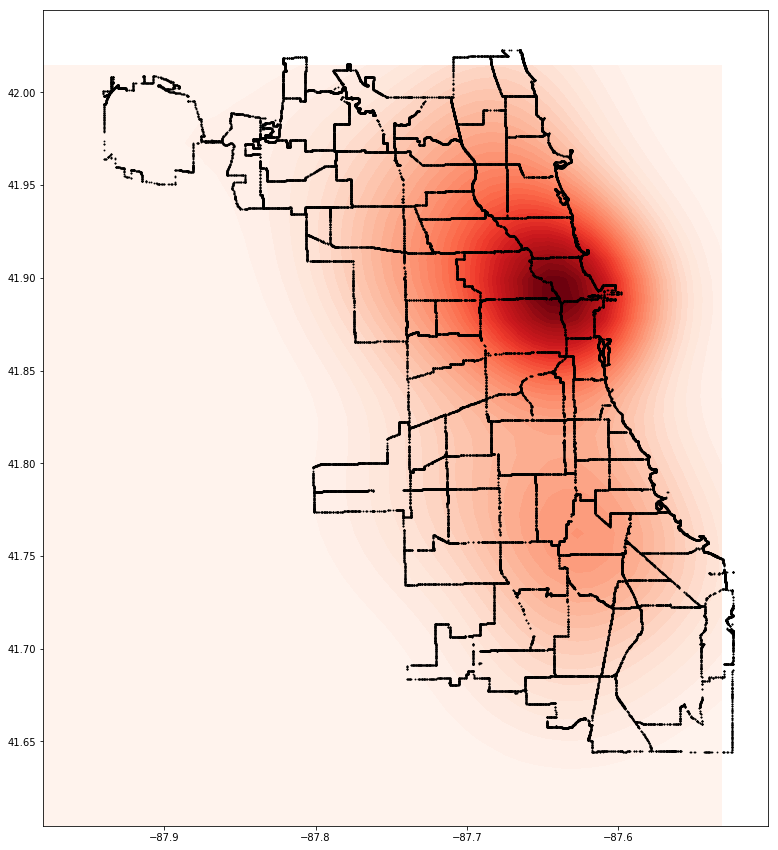

In [17]:
plot_contour(train_dataset['KDE'])

### Sentiment

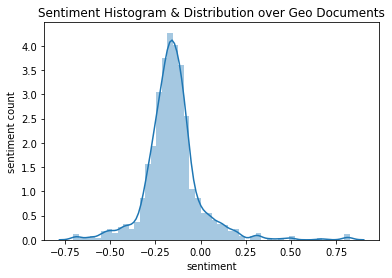

In [18]:
plt.xlabel('sentiment value')
plt.ylabel('sentiment count')
plt.title('Sentiment Histogram & Distribution over Geo Documents')
sns.distplot(train_dataset['SENTIMENT'], norm_hist=True)

In [19]:
# plot_imshow(train_dataset, 'SENTIMENT')

## LDA

In [20]:
print_top_words_LDA(train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 5)

Topic #0: .. | fresh | ☺ | Bacon | Greater
Topic #1: Norridge | url | Lanes | I'm | IL
Topic #2: url | Park | Oak | , | Mansion
Topic #3: url | Avenue | North | West | Foster
Topic #4: - | cabin | ” | “ | remember
Topic #5: : | url | , | ( | )
Topic #6: I | Today | miss | loved | woman
Topic #7: url | , | Berwyn | Illinois | …
Topic #8: url | , | I'm | IL | …
Topic #11: • | url | Studios | … | ‼️
Topic #12: url | … | ou | Eric | grinding
Topic #15: . | party | hard | child | Your
Topic #16: Roseland | Maddix | Mag | Mafia | Mae💋
Topic #17: newest | Ashland | 5328 | Madrid | Mag
Topic #18: url | , | IL | : | latest
Topic #19: url | West | 918 | Space | Event
Topic #21: url | … | ! | , | .
Topic #22: … | . | This | Big | All
Topic #23: url | Baseball | . | Academy | B.I.G.
Topic #30: url | . | … | , | !
Topic #31: Arena | Allstate | url | … | b96chicago
Topic #32: I | url | … | Washington | George
Topic #36: url | . | … | Down | !
Topic #37: , | action | Gettin | url | great
Topic #38: i

In [21]:
np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[-5:]


array([167, 263, 155, 198,  92])

In [22]:
exmple_topic_id = np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[-1]
print(exmple_topic_id)
example_topic_column_name = 'T{:03}'.format(exmple_topic_id)

92


In [23]:
get_topic_top_words_LDA(exmple_topic_id, train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

['url',
 ',',
 'IL',
 ':',
 '-',
 '?',
 'latest',
 '!',
 '…',
 'opening',
 'work',
 "We're",
 'Can',
 'recommend',
 'apply']

In [24]:
# plot_imshow(train_dataset['X'][~train_dataset['Y']], example_topic_column_name)

## Prediction

In [25]:
surveillance_data, threat_datasets = generate_surveillance_data(train_dataset,
                                                                evaluation_dataset)

### Logic Regression Coefs

Most dominant coefs indices: [1 0]


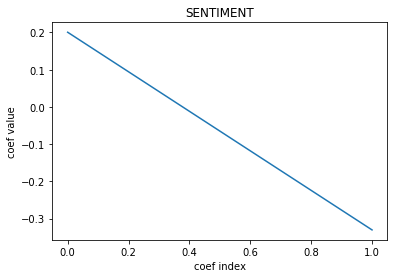

In [26]:
plot_log_reg_coef(threat_datasets, 'SENTIMENT')


In [27]:
threat_datasets['SENTIMENT']['logreg']

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=7.3370110330992979, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

Most dominant coefs indices: [187 125   2 296   3]


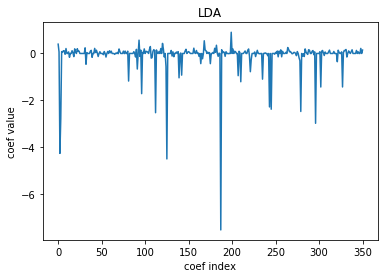

In [28]:
plot_log_reg_coef(threat_datasets, 'LDA')

Most dominant coefs indices: [188 126   3 297   4]


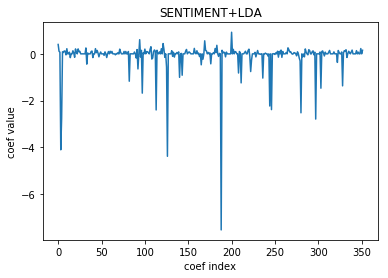

In [29]:
most_dominant_coefs_index = plot_log_reg_coef(threat_datasets, 'SENTIMENT+LDA')



In [30]:
get_topic_top_words_LDA(most_dominant_coefs_index,
                        train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)


['\U0001f9e6',
 'Madre',
 'Mag',
 'Mafia',
 'Mae💋',
 'Maestroshave',
 'Mae',
 'Madrigal',
 'Madrid',
 'Madonna',
 'Magazine',
 'Madness',
 'Madman',
 'Madison/Wabash',
 'Madison']

### Threat Maps

In [31]:
# plot_imshow(threat_datasets['KDE']['df'], 'KDE')




In [32]:
# plot_imshow(threat_datasets['SENTIMENT']['df'], 'SENTIMENT')




In [33]:
# plot_imshow(threat_datasets['LDA']['df'], 'LDA')


In [34]:
# plot_imshow(threat_datasets['SENTIMENT+LDA']['df'], 'SENTIMENT+LDA')


## Surveillance Plot & AUC

,KDE,SENTIMENT,LDA,SENTIMENT+LDA
SENTIMENT,0.1071,,,
LDA,0.2813,0.1742,,
SENTIMENT+LDA,0.2813,0.1742,0.0000,
GOLD,0.4403,0.3333,0.1591,0.1591


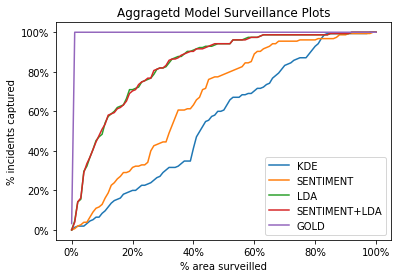

In [37]:
normalized_surveillance_data = surveillance_data.cumsum(axis=1) / surveillance_data.sum(axis=1)[:, None]

plot_surveillance_data(normalized_surveillance_data, threat_datasets.keys())
calc_AUCs(normalized_surveillance_data, threat_datasets.keys())

## Full training

In [ ]:
if True:
    agg_surveillance_data, all_threat_datasets = generate_all_data_surveillance_data(crimes_data, tweets_data, 31)
    
    
    
    

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
plot_surveillance_data(agg_surveillance_data, all_threat_datasets.keys[0]())
calc_AUCs(agg_surveillance_data, all_threat_datasets[0].keys())